In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa

In [2]:
wavs = [file for file in os.listdir('../../dataset/AudioWAV/')]
actors = pd.read_csv('../../dataset/VideoDemographics.csv')

In [3]:
genders = []
ages = []
emotions = []
emotion_levels = []
locations = []

for i, file_name, in enumerate(wavs):
    partition = wavs[i].split('_')
    location = '../../dataset/AudioWAV/' + file_name
    actor_id = partition[0]
    actor_info = actors.loc[actors['ActorID']==int(actor_id), ['Sex', 'Age']].values
    gender = actor_info[0][0]
    age = actor_info[0][1]
    emotion = partition[2]
    emotion_level = partition[3].split('.')[0]
    genders.append(gender)
    ages.append(age)
    emotions.append(emotion)
    emotion_levels.append(emotion_level)
    locations.append(location)

df = pd.DataFrame({'Gender':genders, 'Age':ages, 'Emotion':emotions, 'Emotion levels':emotion_levels, 'Location':locations})

In [4]:
df.head(10)

,Gender,Age,Emotion,Emotion levels,Location
0,Male,51,ANG,XX,../../dataset/AudioWAV/1001_DFA_ANG_XX.wav
1,Male,51,DIS,XX,../../dataset/AudioWAV/1001_DFA_DIS_XX.wav
2,Male,51,FEA,XX,../../dataset/AudioWAV/1001_DFA_FEA_XX.wav
3,Male,51,HAP,XX,../../dataset/AudioWAV/1001_DFA_HAP_XX.wav
4,Male,51,NEU,XX,../../dataset/AudioWAV/1001_DFA_NEU_XX.wav
5,Male,51,SAD,XX,../../dataset/AudioWAV/1001_DFA_SAD_XX.wav
6,Male,51,ANG,HI,../../dataset/AudioWAV/1001_IEO_ANG_HI.wav
7,Male,51,ANG,LO,../../dataset/AudioWAV/1001_IEO_ANG_LO.wav
8,Male,51,ANG,MD,../../dataset/AudioWAV/1001_IEO_ANG_MD.wav
9,Male,51,DIS,HI,../../dataset/AudioWAV/1001_IEO_DIS_HI.wav


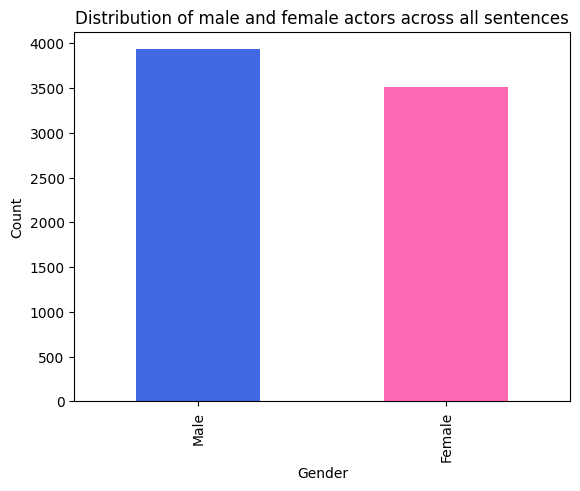

In [5]:
gender_counts = df['Gender'].value_counts()
colors = {'Male': 'royalblue', 'Female': 'hotpink'}
gender_counts.plot(kind='bar', color=[colors.get(gender, 'gray') for gender in gender_counts.index])
plt.ylabel('Count')
plt.title('Distribution of male and female actors across all sentences')
plt.show()

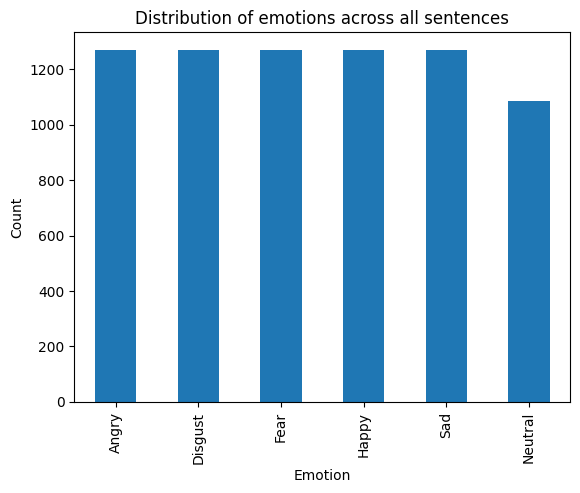

In [6]:
emotions_counts = df['Emotion'].value_counts()
emotion_mapping = {
    'ANG': 'Angry',
    'HAP': 'Happy',
    'SAD': 'Sad',
    'FEA': 'Fear',
    'DIS': 'Disgust',
    'NEU': 'Neutral'
}
emotions_counts = emotions_counts.rename(index=emotion_mapping)
emotions_counts.plot(kind='bar')
plt.ylabel('Count')
plt.title('Distribution of emotions across all sentences')
plt.show()

### Extracting acoustic features

In [19]:
# Mel-Frequency Cepstral Coefficients
def mfccs(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    return mfcc, mfcc_delta, mfcc_delta2

# Mel-Spectrogram
def mel_spec(y, sr):
    melspect = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(melspect, ref=np.max)
    return mel_spec_db

# Spectral Centroid
def spectral_centroid(y, sr):
    return librosa.feature.spectral_centroid(y=y, sr=sr)

# Zero Crossing Rate (ZCR)
def zero_crossings(y):
    return librosa.feature.zero_crossing_rate(y=y)

In [20]:
def extract_acoustic_features(y, sr):
    features = {}

    mfcc, mfcc_delta, mfcc_delta2 = mfccs(y=y, sr=sr)
    features['mfcc'] = mfcc
    features['mfcc_delta'] = mfcc_delta
    features['mfcc_delta2'] = mfcc_delta2

    features['mel_spec_db'] = mel_spec(y=y, sr=sr)

    features['spectral_centroid'] = spectral_centroid(y=y, sr=sr)

    features['zcr'] = zero_crossings(y=y)

    return features

def visualize_features(features, sr):
    plt.figure(figsize=(15, 10))
    
    # MFCCs
    plt.subplot(3, 1, 1)
    librosa.display.specshow(features['mfcc'], x_axis='time', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCCs')
    
    # MFCC Deltas (Δ)
    plt.subplot(3, 1, 2)
    librosa.display.specshow(features['mfcc_delta'], x_axis='time', cmap='viridis')
    plt.colorbar()
    plt.title('MFCC Δ (Velocity)')
    
    # MFCC Delta-Deltas (ΔΔ)
    plt.subplot(3, 1, 3)
    librosa.display.specshow(features['mfcc_delta2'], x_axis='time', cmap='viridis')
    plt.colorbar()
    plt.title('MFCC ΔΔ (Acceleration)')
    plt.tight_layout()
    plt.show()

    # Mel-Spectrogram (dB)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(features['mel_spec_db'], x_axis='time', y_axis='mel', sr=sr, cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram (dB)')
    plt.show()

    plt.figure(figsize=(12, 8))
    
    # Spectral Centroid
    plt.subplot(2, 1, 1)
    times = librosa.times_like(features['spectral_centroid'], sr=sr)
    plt.plot(times, features['spectral_centroid'].T, label='Spectral Centroid', color='b')
    plt.ylabel('Spectral Centroid (Hz)')
    plt.title('Spectral Centroid')
    
    # Zero Crossing Rate (ZCR)
    plt.subplot(2, 1, 2)
    plt.plot(times, features['zcr'].T, label='ZCR', color='r')
    plt.xlabel('Time (s)')
    plt.ylabel('ZCR')
    plt.title('Zero Crossing Rate')
    
    plt.tight_layout()
    plt.show()

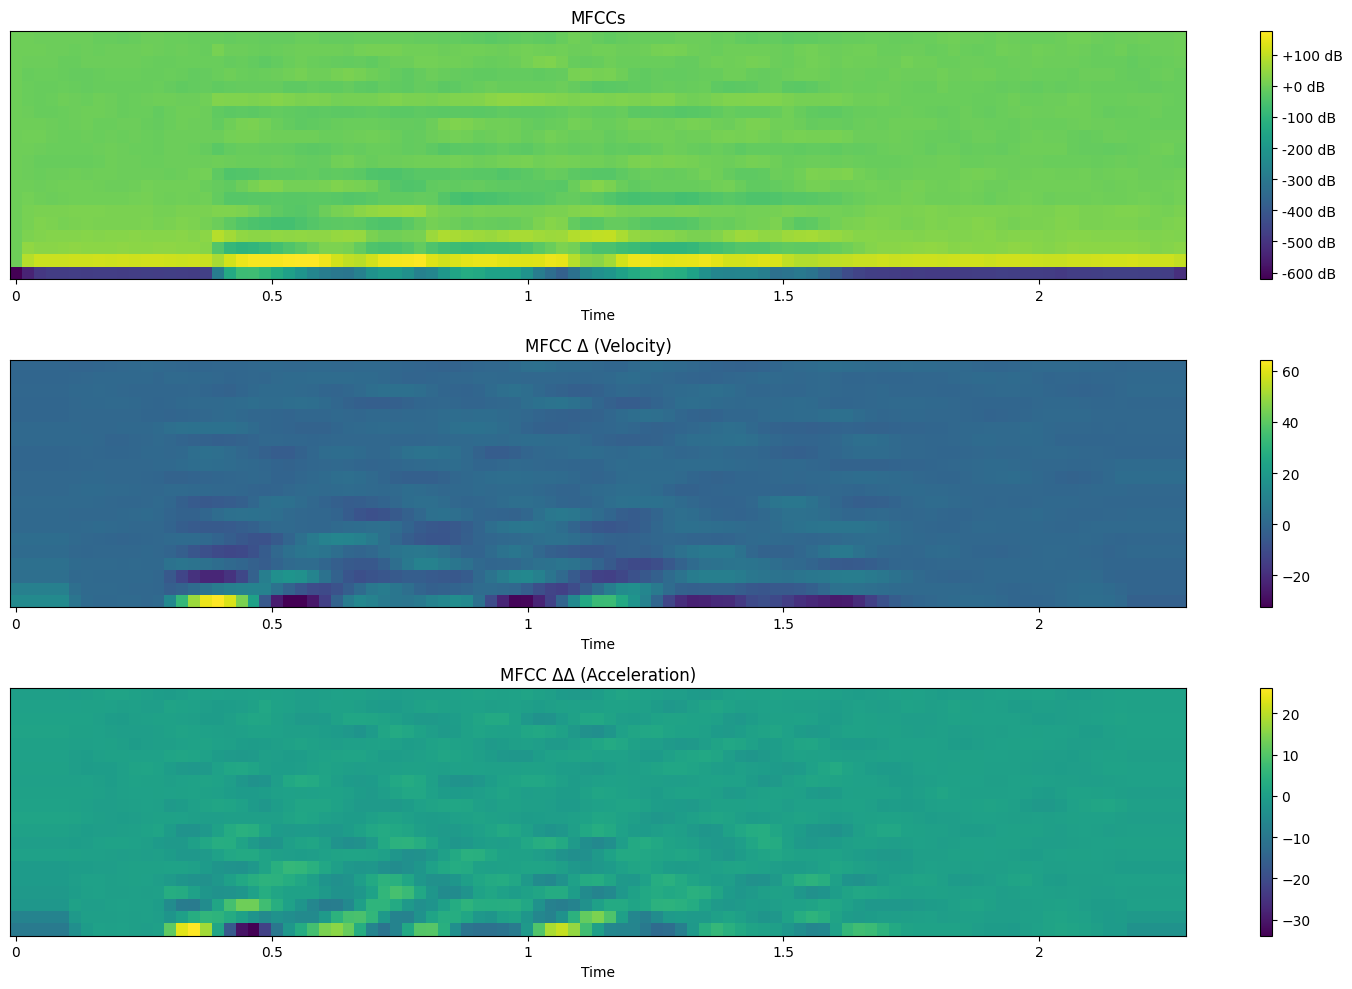

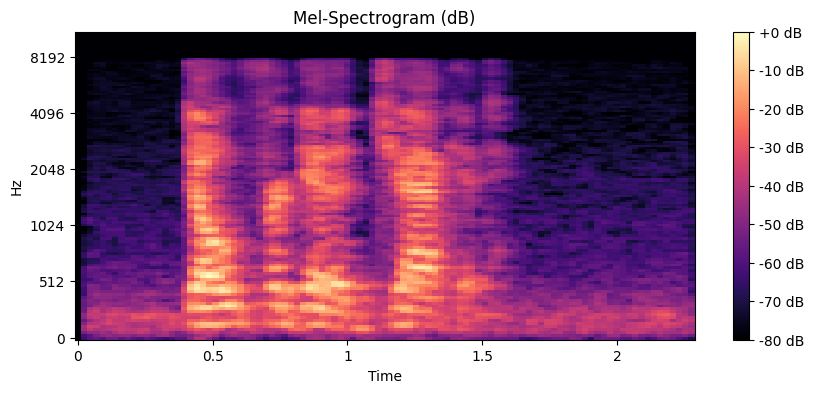

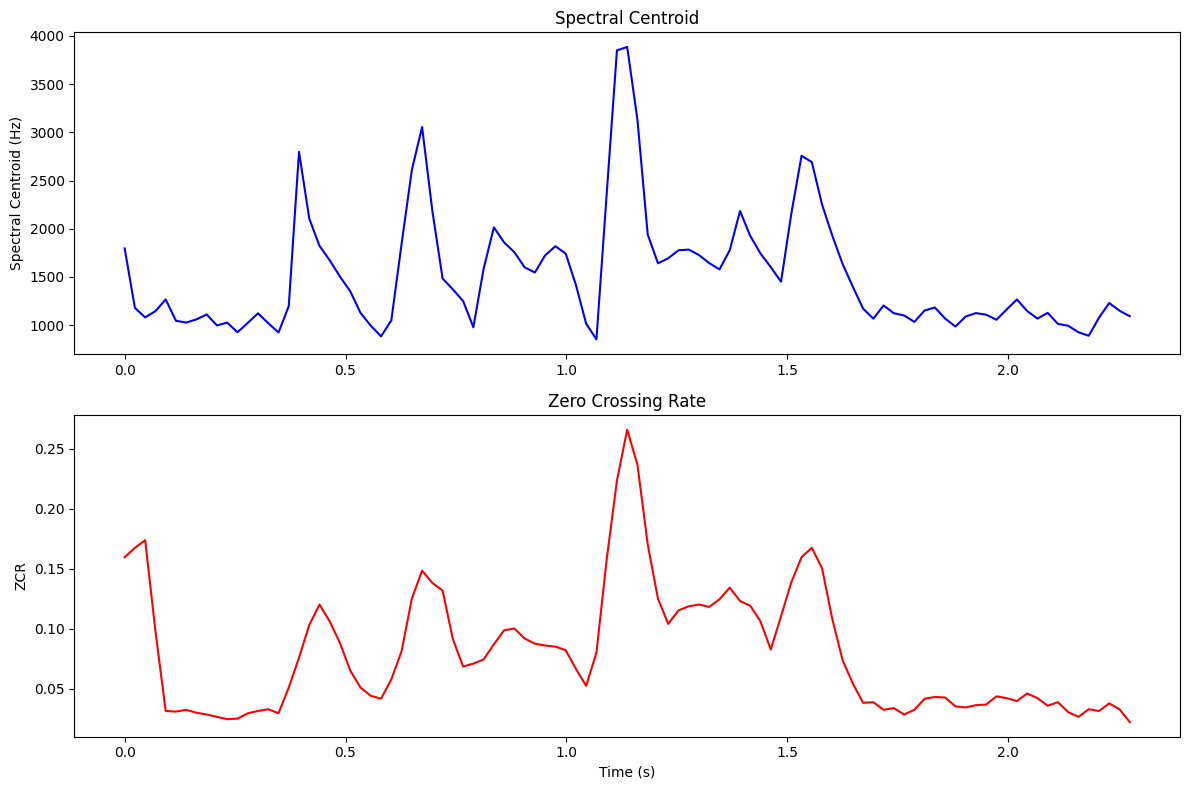

In [9]:
path = '../../dataset/AudioWAV/1001_DFA_ANG_XX.wav'
y, sr = librosa.load(path)

features = extract_acoustic_features(y, sr)
visualize_features(features, sr)

In [10]:
def aggregate_features(features):
    aggregated = {}
    
    aggregated['mfcc_mean'] = np.mean(features['mfcc'], axis=1).tolist()
    aggregated['mfcc_delta_mean'] = np.mean(features['mfcc_delta'], axis=1).tolist()
    aggregated['mfcc_delta2_mean'] = np.mean(features['mfcc_delta2'], axis=1).tolist()

    aggregated['mel_spec_db_mean'] = np.mean(features['mel_spec_db'], axis=1).tolist()

    aggregated['spectral_centroid_mean'] = np.mean(features['spectral_centroid'])

    aggregated['zcr_mean'] = np.mean(features['zcr'])
    
    return aggregated

In [11]:
mfcc_mean = []
mfcc_delta_mean = []
mfcc_delta2_mean = []
mel_spec_db_mean = []
spectral_centroid_mean = []
zcr_mean = []

for index, row in df.iterrows():
    y, sr = librosa.load(row['Location'])
    features = extract_acoustic_features(y, sr)
    aggregated_features = aggregate_features(features)
    mfcc_mean.append(aggregated_features['mfcc_mean'])
    mfcc_delta_mean.append(aggregated_features['mfcc_delta_mean'])
    mfcc_delta2_mean.append(aggregated_features['mfcc_delta2_mean'])
    mel_spec_db_mean.append(aggregated_features['mel_spec_db_mean'])
    spectral_centroid_mean.append(aggregated_features['spectral_centroid_mean'])
    zcr_mean.append(aggregated_features['zcr_mean'])

df['mfcc_mean'] = mfcc_mean
df['mfcc_delta_mean'] = mfcc_delta_mean
df['mfcc_delta2_mean'] = mfcc_delta2_mean
df['mel_spec_db_mean'] = mel_spec_db_mean
df['spectral_centroid_mean'] = spectral_centroid_mean
df['zcr_mean'] = zcr_mean

In [12]:
df

,Gender,Age,Emotion,Emotion levels,Location,mfcc_mean,mfcc_delta_mean,mfcc_delta2_mean,mel_spec_db_mean,spectral_centroid_mean,zcr_mean
0,Male,51,ANG,XX,../../dataset/AudioWAV/1001_DFA_ANG_XX.wav,"[-341.9889221191406, 120.79996490478516, -9.83...","[0.6921295523643494, 0.4810692071914673, 0.032...","[-0.6971630454063416, -0.4661799669265747, -0....","[-54.73905563354492, -48.92445373535156, -41.5...",1516.157973,0.080581
1,Male,51,DIS,XX,../../dataset/AudioWAV/1001_DFA_DIS_XX.wav,"[-388.4619445800781, 133.88211059570312, -17.7...","[0.08185644447803497, 0.11408255249261856, -0....","[-0.18879133462905884, -0.041042305529117584, ...","[-44.846012115478516, -38.46656799316406, -29....",1457.589671,0.069094
2,Male,51,FEA,XX,../../dataset/AudioWAV/1001_DFA_FEA_XX.wav,"[-352.20843505859375, 115.79106903076172, -3.4...","[-0.008709535002708435, -0.020871829241514206,...","[-0.04695381596684456, -0.026446426287293434, ...","[-57.0617561340332, -52.04328918457031, -44.93...",1421.898267,0.062765
3,Male,51,HAP,XX,../../dataset/AudioWAV/1001_DFA_HAP_XX.wav,"[-337.8395690917969, 120.10960388183594, -12.6...","[-0.06729506701231003, 0.0923130139708519, -0....","[-0.23044784367084503, -0.11276459693908691, 0...","[-54.53754806518555, -50.639713287353516, -44....",1481.793207,0.063893
4,Male,51,NEU,XX,../../dataset/AudioWAV/1001_DFA_NEU_XX.wav,"[-368.1755676269531, 124.36493682861328, -4.64...","[0.3937581777572632, 0.01509196124970913, -0.1...","[0.0973547175526619, -0.028145724907517433, -0...","[-52.723148345947266, -46.654727935791016, -40...",1424.198808,0.061546
...,...,...,...,...,...,...,...,...,...,...,...
7437,Female,29,DIS,XX,../../dataset/AudioWAV/1091_WSI_DIS_XX.wav,"[-454.6822814941406, 133.6008758544922, 11.282...","[0.05152149498462677, 0.06501112133264542, 0.0...","[-0.06592003256082535, 0.01195275317877531, -0...","[-29.87012481689453, -22.10732078552246, -20.8...",1616.733265,0.089559
7438,Female,29,FEA,XX,../../dataset/AudioWAV/1091_WSI_FEA_XX.wav,"[-465.70709228515625, 127.06690216064453, 14.2...","[0.020788749679923058, 0.10153426975011826, -0...","[0.19472771883010864, 0.0011084007564932108, -...","[-30.286949157714844, -23.437721252441406, -22...",1550.965648,0.072627
7439,Female,29,HAP,XX,../../dataset/AudioWAV/1091_WSI_HAP_XX.wav,"[-410.9172058105469, 124.26668548583984, 8.617...","[0.7939563393592834, -0.12376718968153, -0.135...","[-0.663468599319458, 0.24786242842674255, 0.09...","[-36.47106170654297, -29.10075569152832, -27.9...",1704.955902,0.102575
7440,Female,29,NEU,XX,../../dataset/AudioWAV/1091_WSI_NEU_XX.wav,"[-429.4551086425781, 122.09678649902344, 19.65...","[-0.08798504620790482, 0.2889360189437866, 0.0...","[-0.12654204666614532, -0.007811230141669512, ...","[-38.182613372802734, -30.556838989257812, -29...",1667.725824,0.085759


In [13]:
path = '../../dataset/'
path = os.path.join(path, 'features.csv')
df.to_csv(path, index=False)